In [2]:
from re import sub, compile
from requests import get, exceptions
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams, savefig
import matplotlib
from gensim.utils import tokenize
from nltk import sent_tokenize
from itertools import chain
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models, corpora
from pymorphy2 import MorphAnalyzer

Утилсы: регулярки, загрузка файлов и т.д.

In [1]:
def cut(data):
    r = compile(r'<.*?>|>>.*|&#(47|92);|&quot;|&gt;|(http|https):.*')
    return r.sub('', data)

def punctuate(data):
    r = compile( r'([a-zA-Z])([,.!])', r'\1 \2')
    return r.sub('', data)

def pos_cut(s):
    s = sub(r"ADJF", "ADJ", s)
    s = sub(r"ADVB", "ADV", s)
    s = sub(r"INFN", "VERB", s)
    return s

def topic_cut(word):
    return sub('[^a-zA-Zа-яА-Я]', '', word)

def check_for_rus_lan(word):
    regex = compile('[А-Яа-я]+$')
    if regex.match(word):
        return True
    return False

Загрузка каталога тредов выбранной доски

In [2]:
DVACH = 'https://2ch.hk/'
BOARD = 'pr'

dvach_page = get(DVACH + BOARD + '/catalog.json').json()
threads = [i['num'] for i in dvach_page['threads']]

Распределение по длинам постов для доски

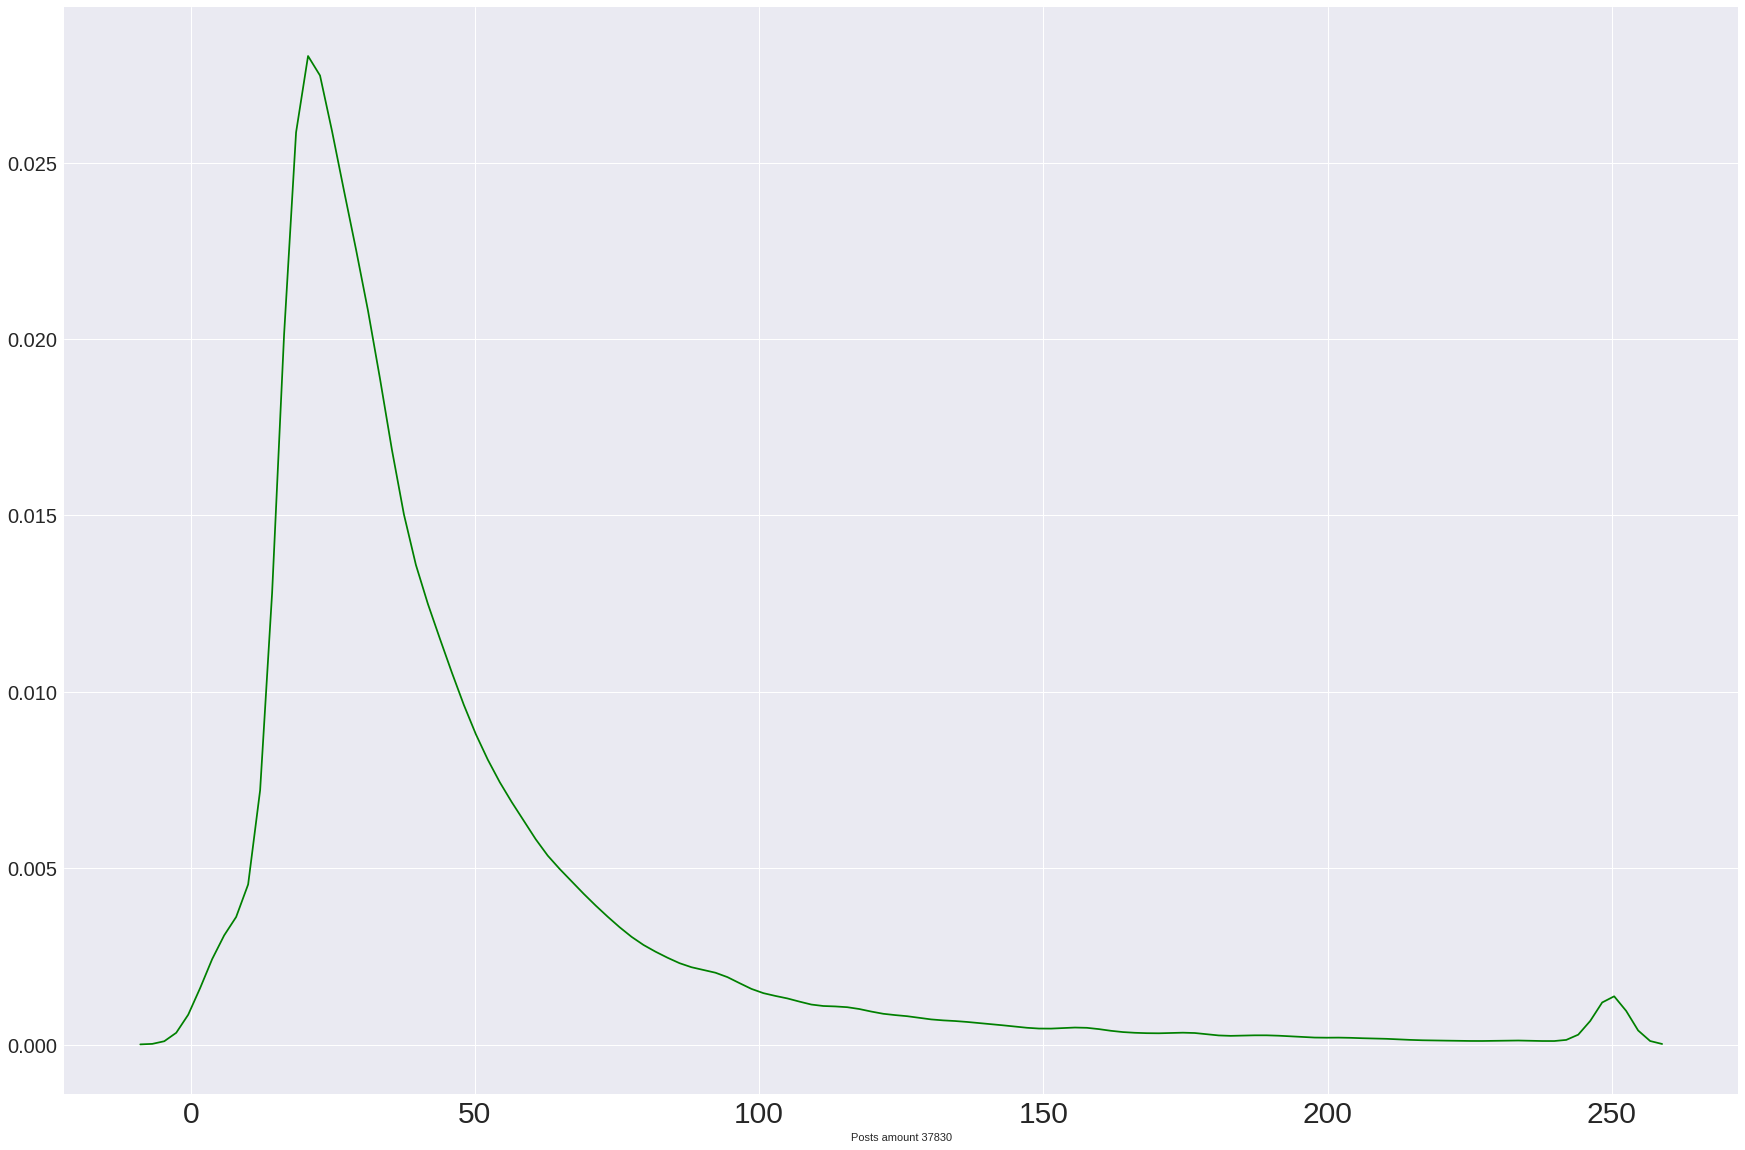

In [3]:
%matplotlib inline

posts_lengths = []

for thread in threads:
    try:
        thread = get(DVACH +  BOARD + '/res/' + thread + '.json',  timeout=5).json()
        [posts_lengths.append(len(list(tokenize(i['comment'])))) for i in thread['threads'][0]['posts'] if len(i['comment']) > 2]
    except:
        pass
    
# Remove noise
for index, item in enumerate(posts_lengths):
    if item > 250:
        posts_lengths[index] = 250
    if item < 0:
        posts_lengths[index] = 250

rcParams['figure.figsize'] = 30, 20
params = {'xtick.labelsize': 30, 'ytick.labelsize': 20}
matplotlib.rcParams.update(params)


posts_lengths = posts_lengths[1:]
len(posts_lengths)


x = pd.Series(posts_lengths, name = 'Posts amount ' + str(len(posts_lengths)))
sns.distplot(x, bins=100, rug=False, hist=False, color='green')
savefig(BOARD + '.png')

Получение корпуса сообщений из выбранного треда

In [7]:
documents = []

for every_thread in threads:
    try:
        thread = get(DVACH +  BOARD + '/res/' + every_thread + '.json', timeout=5).json()
        [documents.append(sent_tokenize(cut(i['comment']))) for i in thread['threads'][0]['posts'] if len(cut(i['comment'])) > 2]
    except:
        pass
documents = list(chain.from_iterable(documents))

Загрузка токенизатора, токенизация данных

In [8]:
stop = stopwords.words('russian')
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')
morph = pymorphy2.MorphAnalyzer()

def my_tokenize(sent):
    sents = list(alpha_tokenizer.tokenize(sent))
    return set([morph.parse(sent.lower())[0].normal_form for sent in sents if sent.lower() not in stop and len(sent.lower()) > 1])

model_data = [my_tokenize(sent) for sent in documents]

Получение TF-IDF весов для корпуса и инициализация словаря, в котором каждому слову ассоциирован вес

In [11]:
corpus = documents
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
d = dict(zip(vectorizer.get_feature_names(), idf))

Проверка работы TF-IDF модели

In [12]:
for i in list(alpha_tokenizer.tokenize(('попробуй использовать С'))):
    weight = 0
    if not i in stop:
        try:
            weight = round(d[i], 2)
        except:
            pass
    print(i, weight)

попробуй 8.69
использовать 5.62


Создание LDA модели

In [8]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=5)
lda.print_topics(5)

[(0,
  '0.256*"сообщения" + 0.256*"первого" + 0.251*"почему" + 0.140*"строки" + 0.024*"типа" + 0.024*"посчитать" + 0.024*"return" + 0.024*"result"'),
 (1,
  '0.130*"почему" + 0.129*"типа" + 0.126*"посчитать" + 0.123*"строки" + 0.123*"return" + 0.123*"первого" + 0.123*"сообщения" + 0.123*"result"'),
 (2,
  '0.602*"посчитать" + 0.059*"почему" + 0.058*"типа" + 0.056*"строки" + 0.056*"сообщения" + 0.056*"return" + 0.056*"первого" + 0.056*"result"'),
 (3,
  '0.256*"result" + 0.255*"return" + 0.255*"типа" + 0.139*"строки" + 0.024*"почему" + 0.024*"посчитать" + 0.024*"первого" + 0.024*"сообщения"'),
 (4,
  '0.452*"типа" + 0.081*"почему" + 0.079*"посчитать" + 0.078*"строки" + 0.078*"return" + 0.078*"первого" + 0.077*"сообщения" + 0.077*"result"')]

Создание LSI модели

In [9]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=1) # initialize an LSI transformation
corpus_lsi = lsi[corpus]
lda.print_topics(5)

[(0,
  '0.256*"сообщения" + 0.256*"первого" + 0.251*"почему" + 0.140*"строки" + 0.024*"типа" + 0.024*"посчитать" + 0.024*"return" + 0.024*"result"'),
 (1,
  '0.130*"почему" + 0.129*"типа" + 0.126*"посчитать" + 0.123*"строки" + 0.123*"return" + 0.123*"первого" + 0.123*"сообщения" + 0.123*"result"'),
 (2,
  '0.602*"посчитать" + 0.059*"почему" + 0.058*"типа" + 0.056*"строки" + 0.056*"сообщения" + 0.056*"return" + 0.056*"первого" + 0.056*"result"'),
 (3,
  '0.256*"result" + 0.255*"return" + 0.255*"типа" + 0.139*"строки" + 0.024*"почему" + 0.024*"посчитать" + 0.024*"первого" + 0.024*"сообщения"'),
 (4,
  '0.452*"типа" + 0.081*"почему" + 0.079*"посчитать" + 0.078*"строки" + 0.078*"return" + 0.078*"первого" + 0.077*"сообщения" + 0.077*"result"')]

Получение списка характеризующих тему слов

In [10]:
topics = lda.print_topic(1)
keywords= [topic_cut(word) for word in topics.split('+')]
keywords

['почему',
 'типа',
 'посчитать',
 'строки',
 'return',
 'первого',
 'сообщения',
 'result']

Загрузка обученной модели RusVectores

In [11]:
model = models.KeyedVectors.load_word2vec_format('corpora.bin', binary=True)

Предобработчик токенов для использования модели RusVectores

In [25]:
morph = MorphAnalyzer()

def process(s):
    if not check_for_rus_lan(s):
        return None
    s += '_' + morph.parse(s)[0].tag.POS
    s = pos_cut(s)
    return s

Расстояние от слова до ключевых слов тематического кластера

In [26]:
similarities = [[model.similarity(process('программирование'), process(keyword)), keyword] for keyword in keywords if process(keyword) in model.vocab]
similarities

[[0.083447638458197956, 'посчитать']]

#TODO суммарное расстояние всего сообщения